# Imports

In [32]:
import json, random

In [33]:
from market import Market, Produto

In [34]:
from IPython.display import display

# Static Values

In [35]:
CART: dict = {
    'Altura': 65,
    'Largura': 50,
    'Comprimento': 80,
    'PesoMaximo': 460*1000
}

CART['Capacidade'] = CART['Altura'] * CART['Largura'] * CART['Comprimento']

CART

{'Altura': 65,
 'Largura': 50,
 'Comprimento': 80,
 'PesoMaximo': 460000,
 'Capacidade': 260000}

In [36]:
MAX_MONEY: float = 2000.0
MAX_ITEMS: int = 10
MAX_CARTS: int = MAX_ITEMS*10
MAX_GENERATIONS: int = 1000
BESTS: int = 15

# Funções

In [37]:
m: Market = Market(r"C:\Users\Arklok\Documents\Projetos\gen-algorithm\data\produtos.csv")

# Genético

### Geração de Indivíduos

In [38]:
def gerar_carrinho(tamanho: int = globals()['MAX_ITEMS']) -> list[Produto]:
    compra = []

    while len(compra) < tamanho:
        item: Produto = m.random()
        compra.append(item)
        
    return compra

In [39]:
c: list[Produto] = gerar_carrinho()
c

[<Produto(id=129104>,
 <Produto(id=365990>,
 <Produto(id=51876>,
 <Produto(id=86987>,
 <Produto(id=70008>,
 <Produto(id=457507>,
 <Produto(id=165385>,
 <Produto(id=137290>,
 <Produto(id=1568669>,
 <Produto(id=1387081>]

### Geração de População Inicial

In [40]:
def gerar_populacao(tamanho: int = globals()['MAX_CARTS']) -> list[list[Produto]]:
    return [gerar_carrinho() for _ in range(tamanho)]

In [41]:
p: list[list[Produto]] = gerar_populacao()
p

[[<Produto(id=181458>,
  <Produto(id=1440416>,
  <Produto(id=365990>,
  <Produto(id=74109>,
  <Produto(id=318906>,
  <Produto(id=162383>,
  <Produto(id=22595>,
  <Produto(id=323696>,
  <Produto(id=337821>,
  <Produto(id=1616960>],
 [<Produto(id=343634>,
  <Produto(id=95963>,
  <Produto(id=505570>,
  <Produto(id=1497103>,
  <Produto(id=113253>,
  <Produto(id=1471541>,
  <Produto(id=470253>,
  <Produto(id=476990>,
  <Produto(id=1614978>,
  <Produto(id=409355>],
 [<Produto(id=345967>,
  <Produto(id=384522>,
  <Produto(id=472418>,
  <Produto(id=337821>,
  <Produto(id=467415>,
  <Produto(id=324113>,
  <Produto(id=588924>,
  <Produto(id=403397>,
  <Produto(id=467658>,
  <Produto(id=1623457>],
 [<Produto(id=125107>,
  <Produto(id=190728>,
  <Produto(id=24186>,
  <Produto(id=101493>,
  <Produto(id=58351>,
  <Produto(id=198166>,
  <Produto(id=411008>,
  <Produto(id=1379112>,
  <Produto(id=315604>,
  <Produto(id=84242>],
 [<Produto(id=418932>,
  <Produto(id=1614082>,
  <Produto(id=174284>,
  <Pr

### Avaliação

In [42]:
# def avaliar(individuo: list[Produto], valor_limite: float = globals()['MAX_MONEY']) -> float:
#     valor_compra: float = 0.0
    
#     for item in individuo:
#         valor_compra += item.price

#     if valor_compra > valor_limite:
#         return float('inf')
    
#     else:
#         return valor_compra

In [43]:
def avaliar(individuo: list[Produto], 
            valor_limite: float = globals()['MAX_MONEY'], 
            max_peso: float = CART['PesoMaximo'], 
            max_volume: float = CART['Capacidade'],
            max_itens: int = globals()['MAX_ITEMS']
            ) -> float:

    valor_compra: float = 0.0
    peso_total: float = 0.0
    volume_total: float = 0.0
    categorias: set = set()
    repeticoes: int = 0

    for item in individuo:
        valor_compra += item.price
        peso_total += item.weight
        volume_item = item.height * item.width * item.depth
        volume_total += volume_item
        
        categorias.add(item.category)
        
        # Contar repetições de produtos
        if individuo.count(item) > 1:
            repeticoes += 1

    # Penalidades
    nota = 0.0

    # Penalidade por exceder o limite de dinheiro
    if valor_compra > valor_limite:
        nota += (valor_compra - valor_limite) * 10  # Ajuste de penalidade
    
    # Penalidade por excesso de peso
    if peso_total > max_peso:
        nota += (peso_total - max_peso) * 15  # Ajuste de penalidade

    # Penalidade por excesso de volume
    if volume_total > max_volume:
        nota += (volume_total - max_volume) * 20  # Ajuste de penalidade

    # Penalidade por número excessivo de itens
    if len(individuo) > max_itens:
        nota += (len(individuo) - max_itens) * 5  # Ajuste de penalidade

    # Penalidade por repetição de produtos
    nota += repeticoes * 10  # Penalidade por cada produto repetido

    # Incentivo pela diversidade de categorias
    nota -= len(categorias) * 5  # Deduz nota pela diversidade de categorias

    # Final result is the total cost plus penalizations
    return valor_compra + nota


In [44]:
n: float = avaliar(c)
n

242.48000000000002

In [45]:
def mapear_notas(populacao: list[list[Produto]], order: str = 'asc') -> dict[float, list[Produto]]:
    notas: dict = {avaliar(individuo): individuo for individuo in populacao}
    
    if order == 'asc':
        return dict(sorted(notas.items()))
    
    else:
        return dict(sorted(notas.items(), reverse=True))

In [46]:
nt: dict[float, list[Produto]] = mapear_notas(p)
nt

{55.599999999999994: [<Produto(id=174511>,
  <Produto(id=69291>,
  <Produto(id=328080>,
  <Produto(id=1591034>,
  <Produto(id=284066>,
  <Produto(id=318906>,
  <Produto(id=17527>,
  <Produto(id=53226>,
  <Produto(id=335996>,
  <Produto(id=80070>],
 70.32: [<Produto(id=343634>,
  <Produto(id=95963>,
  <Produto(id=505570>,
  <Produto(id=1497103>,
  <Produto(id=113253>,
  <Produto(id=1471541>,
  <Produto(id=470253>,
  <Produto(id=476990>,
  <Produto(id=1614978>,
  <Produto(id=409355>],
 102.78: [<Produto(id=470249>,
  <Produto(id=467613>,
  <Produto(id=165385>,
  <Produto(id=36522>,
  <Produto(id=162383>,
  <Produto(id=419634>,
  <Produto(id=695249>,
  <Produto(id=1616943>,
  <Produto(id=42870>,
  <Produto(id=138477>],
 108.24000000000001: [<Produto(id=127976>,
  <Produto(id=760243>,
  <Produto(id=1616741>,
  <Produto(id=479199>,
  <Produto(id=364472>,
  <Produto(id=103465>,
  <Produto(id=595320>,
  <Produto(id=1379112>,
  <Produto(id=1623170>,
  <Produto(id=9461>],
 111.89999999999998: [

### Seleção

In [47]:
def torneio(populacao: list[list[Produto]]) -> list[list[Produto]]:
    vencedores: list[list[Produto] | None] = []
    
    while len(vencedores) < 2:
        competidor_1: list[Produto] = random.choice(populacao)
        competidor_2: list[Produto] = random.choice(populacao)
                
        # Seleção do melhor individuo:
        if avaliar(competidor_1) < avaliar(competidor_2):
            vencedor: list[Produto] = competidor_1
        
        else:
            vencedor: list[Produto] = competidor_2
            
        if vencedor not in vencedores:
            vencedores.append(vencedor)
    
    return vencedores

In [48]:
v: list[list[Produto]] = torneio(p)
v

[[<Produto(id=1471541>,
  <Produto(id=1624532>,
  <Produto(id=97938>,
  <Produto(id=1621537>,
  <Produto(id=22729>,
  <Produto(id=1613314>,
  <Produto(id=1384441>,
  <Produto(id=197994>,
  <Produto(id=529898>,
  <Produto(id=77655>],
 [<Produto(id=1616578>,
  <Produto(id=1538480>,
  <Produto(id=173742>,
  <Produto(id=30116>,
  <Produto(id=173742>,
  <Produto(id=455623>,
  <Produto(id=794143>,
  <Produto(id=25181>,
  <Produto(id=478018>,
  <Produto(id=89512>]]

In [49]:
def eugenia(populacao: list[list[Produto]], order: str = 'asc') -> list[list[Produto]]:
    notas: dict[float, list[Produto]] = mapear_notas(populacao, order)
    melhores: list[list[Produto]] = list(notas.values())[:globals()['BESTS']]
    
    return melhores

In [50]:
e: list[list[Produto]] = eugenia(p)
e

[[<Produto(id=174511>,
  <Produto(id=69291>,
  <Produto(id=328080>,
  <Produto(id=1591034>,
  <Produto(id=284066>,
  <Produto(id=318906>,
  <Produto(id=17527>,
  <Produto(id=53226>,
  <Produto(id=335996>,
  <Produto(id=80070>],
 [<Produto(id=343634>,
  <Produto(id=95963>,
  <Produto(id=505570>,
  <Produto(id=1497103>,
  <Produto(id=113253>,
  <Produto(id=1471541>,
  <Produto(id=470253>,
  <Produto(id=476990>,
  <Produto(id=1614978>,
  <Produto(id=409355>],
 [<Produto(id=470249>,
  <Produto(id=467613>,
  <Produto(id=165385>,
  <Produto(id=36522>,
  <Produto(id=162383>,
  <Produto(id=419634>,
  <Produto(id=695249>,
  <Produto(id=1616943>,
  <Produto(id=42870>,
  <Produto(id=138477>],
 [<Produto(id=127976>,
  <Produto(id=760243>,
  <Produto(id=1616741>,
  <Produto(id=479199>,
  <Produto(id=364472>,
  <Produto(id=103465>,
  <Produto(id=595320>,
  <Produto(id=1379112>,
  <Produto(id=1623170>,
  <Produto(id=9461>],
 [<Produto(id=328080>,
  <Produto(id=118250>,
  <Produto(id=1944>,
  <Produto

### Crossover e Mutação

In [51]:
def cruzamento(pais: list[list[Produto]], chance: float = 0.8) -> list[list[Produto]]:
    pai_1: list[Produto] = pais[0]
    pai_2: list[Produto] = pais[1]

    probabilidade: float = round(random.uniform(0, 1), 2)

    if probabilidade < chance:
        pos: int = random.randint(0, len(pai_1))

        filho_1: list[Produto] = pai_1[:pos] + pai_2[pos:]
        filho_2: list[Produto] = pai_2[:pos] + pai_1[pos:]

        return [filho_1, filho_2]

    else:
        return [pai_1, pai_2]

In [52]:
f: list[list[Produto]] = cruzamento(v)
f

[[<Produto(id=1471541>,
  <Produto(id=1624532>,
  <Produto(id=97938>,
  <Produto(id=1621537>,
  <Produto(id=22729>,
  <Produto(id=1613314>,
  <Produto(id=1384441>,
  <Produto(id=197994>,
  <Produto(id=529898>,
  <Produto(id=77655>],
 [<Produto(id=1616578>,
  <Produto(id=1538480>,
  <Produto(id=173742>,
  <Produto(id=30116>,
  <Produto(id=173742>,
  <Produto(id=455623>,
  <Produto(id=794143>,
  <Produto(id=25181>,
  <Produto(id=478018>,
  <Produto(id=89512>]]

In [53]:
def mutar(populacao: list[list[Produto]], chance = 0.05) -> list[list[Produto]]: 
    mutados: list[list[Produto]] = []

    for individuo in populacao:
        for pos, alelo in enumerate(individuo):
            mutacao: float = round(random.uniform(0, 1), 3)

            if mutacao < chance:
                novo_gene: str = m.random(ignore_case=[alelo,]) 
                individuo: str = f'{individuo[:pos]}{novo_gene}{individuo[pos+1:]}'

        mutados.append(individuo)
    
    return mutados

In [54]:
mt: list[list[Produto]] = mutar(p)
mt

[[<Produto(id=181458>,
  <Produto(id=1440416>,
  <Produto(id=365990>,
  <Produto(id=74109>,
  <Produto(id=318906>,
  <Produto(id=162383>,
  <Produto(id=22595>,
  <Produto(id=323696>,
  <Produto(id=337821>,
  <Produto(id=1616960>],
 [<Produto(id=343634>,
  <Produto(id=95963>,
  <Produto(id=505570>,
  <Produto(id=1497103>,
  <Produto(id=113253>,
  <Produto(id=1471541>,
  <Produto(id=470253>,
  <Produto(id=476990>,
  <Produto(id=1614978>,
  <Produto(id=409355>],
 [<Produto(id=345967>,
  <Produto(id=384522>,
  <Produto(id=472418>,
  <Produto(id=337821>,
  <Produto(id=467415>,
  <Produto(id=324113>,
  <Produto(id=588924>,
  <Produto(id=403397>,
  <Produto(id=467658>,
  <Produto(id=1623457>],
 '[<Produto(id=125107>, <Produto(id=190728>, <Produto(id=24186>, <Produto(id=101493>, <Produto(id=58351>]Product Info\nid: 95963\nname: Suco de Maracujá MAGUARY 1 Litro\nsku: 5690718\nprice: 7.19\nimage: https://static.paodeacucar.com/img/uploads/1/915/18507915.jpg\nbrand: Maguary\ncategory: bebidas\nde

# Execução Principal

In [55]:
if __name__ == '__main__':
    i: int = 0
    
    while i < MAX_GENERATIONS:
        i+=1

        populacao_inicial: list[list[Produto]] = gerar_populacao()
        populacao_atual: list[list[Produto]] = populacao_inicial.copy()
        geracao: list[list[Produto]] = []

        while len(geracao) < MAX_CARTS - BESTS:
            notas: dict[float, list[Produto]] = mapear_notas(populacao_atual)
            
            pais: list[list[Produto]] = torneio(populacao_atual)
            filhos: list[list[Produto]] = cruzamento(pais)
            geracao.extend(filhos)
            
        geracao.extend(eugenia(populacao_atual))
        
        # print(f'Geração: {g} | Melhor: {notas[min(notas.keys())]}')
        populacao_atual: list[list[Produto]] = geracao.copy()
        
best_individual: list[Produto] = eugenia(populacao_atual)[0]
print(
    f"Geração: {i}\nMelhor carrinho: {best_individual}\n"
)

Geração: 1000
Melhor carrinho: [<Produto(id=465035>, <Produto(id=409355>, <Produto(id=173710>, <Produto(id=173595>, <Produto(id=5728>, <Produto(id=1433067>, <Produto(id=409359>, <Produto(id=670165>, <Produto(id=161459>, <Produto(id=365395>]



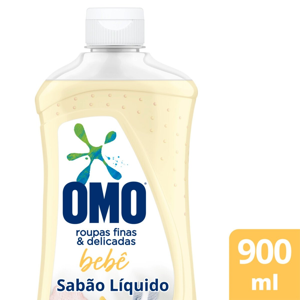

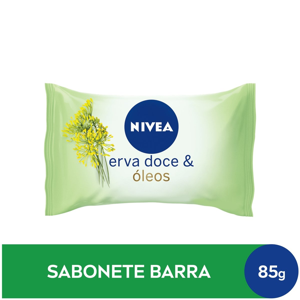

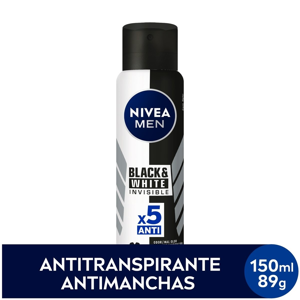

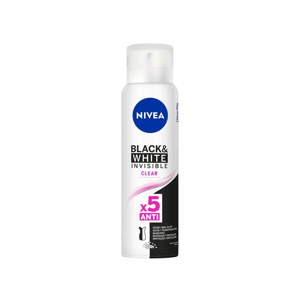

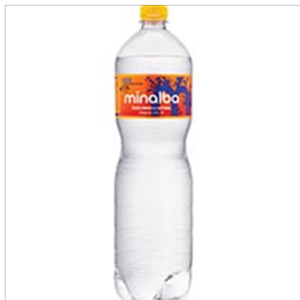

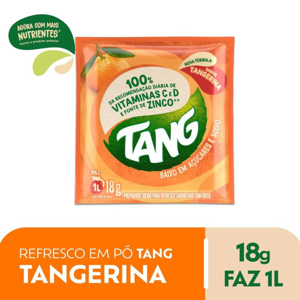

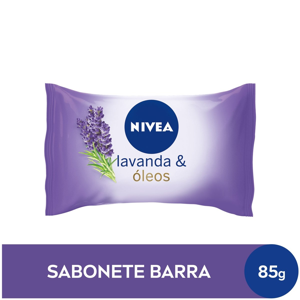

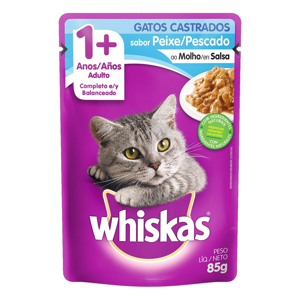

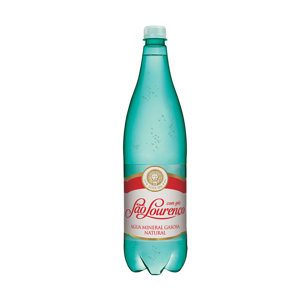

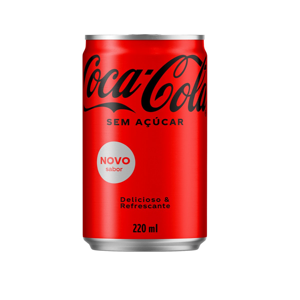

[None, None, None, None, None, None, None, None, None, None]

In [56]:
best_items: list = []
for item in eugenia(populacao_atual)[0]:
    best_items.append(item.show(popup=False))
    
[display(img.resize((300,300))) for img in best_items]